In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 

sns.set_style(style='white')
sns.set_context(context ='paper')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

font_path = 'font/NanumSquareRoundR.ttf'
fontprop = font_manager.FontProperties(fname=font_path)

pd.set_option('display.max_columns',999)

In [3]:
final_df = pd.read_csv('data/time_df_RF.csv')

In [4]:
final_df.tail(1)

,CLNT_ID,SESS_ID,SESS_DT,HITS_SEQ,SESS_SEQ,TOT_SESS_HR_V,PD_BUY_TO,DVC_CTG_NM,ZON_NM,CLNT_GENDER,CLNT_AGE,MONTH,DAY,WEEKDAY,SEARCH_CNT,ONE_PAG_HR_V
2541092,6592554,7240794,20180601,9.0,1.0,1218.0,199900,not_mobile,Gyeonggi-do,F,30.0,6,first,4,0,93.692308


In [5]:
product = pd.read_csv('data/Product.csv')
search1 = pd.read_csv('data/Search1.csv')
search2 = pd.read_csv('data/Search2.csv')
session = pd.read_csv('data/Session.csv')
master = pd.read_csv('data/Master.csv')
custom = pd.read_csv('data/Custom.csv')

C:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# product 이상치 제거
product = product[lambda x : x.HITS_SEQ != 1]

In [7]:
# 똑같은 row 지우기
product.drop_duplicates(inplace = True)
session.drop_duplicates(inplace = True)
search1.drop_duplicates(inplace = True)
search2.drop_duplicates(inplace = True)
master.drop_duplicates(inplace = True)
custom.drop_duplicates(inplace = True)

In [8]:
def time_month(x):
    return int(str(x)[4:6])
    
def time_day(x):
    return int(str(x)[6:])
    
# def time_weekday(x):
#     dt = datetime.datetime(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:]) )
#     return dt.weekday()

In [11]:
search2['MONTH'] = search2.SESS_DT.map(time_month)
search2['DAY'] = search2.SESS_DT.map(time_day)
# search2['WEEKDAY'] = search2.SESS_DT.map(time_weekday)

In [12]:
def int_(x):
    if type(x) == str:
        if ',' in x : 
            return int(''.join(x.split(',')))
        else : 
            return int(x)
    else : 
        return x
    
search2.SEARCH_CNT = search2.SEARCH_CNT.map(int_)

In [13]:
search2.head(1)

,SESS_DT,KWD_NM,SEARCH_CNT,MONTH,DAY
0,20180407,닥스원피스,8,4,7


In [14]:
search2.groupby('KWD_NM')['SEARCH_CNT'].sum().sort_values(ascending = False)[:5]

KWD_NM
원피스       345757
에고이스트     162914
블라우스      161421
에이치커넥트    139829
여성샌들      136928
Name: SEARCH_CNT, dtype: int64

원피스가 가장 많이 팔렸으므로 '원피스' 라는 검색어를 통해 검색어를 통한 수요 트렌드를 예측 해보자

## 검색량을 통한 판매량 예측

- 네이버 데이터랩 사용 : 해당 검색어가 어떤 상품군에 속하는지 알수 없음
- 이전 판매량과 주별, 일별 검색량을 통한 수요 트렌드 예측

### '여성원피스' 가 targetword

In [15]:
targetword_df = search2[lambda x : x.KWD_NM == '원피스'].reset_index(drop = True)

In [16]:
targetword_sold = pd.merge(product, master, how = 'left', on = 'PD_C')
targetword_sold = targetword_sold[lambda x : x.CLAC3_NM.isin(['여성원피스', '영유아원피스']) ]
targetword_sold = pd.merge(targetword_sold, session, how = 'left', on = ['CLNT_ID','SESS_ID'])

In [17]:
targetword_sold = targetword_sold[['SESS_DT','PD_BUY_CT']]  
targetword_sold['PD_BUY_CT'] = targetword_sold.PD_BUY_CT.map(int_)

In [18]:
targetword_sold.head(1)

,SESS_DT,PD_BUY_CT
0,20180403,1


In [19]:
targetword_df.head(1)

,SESS_DT,KWD_NM,SEARCH_CNT,MONTH,DAY
0,20180421,원피스,1850,4,21


In [20]:
target_df = pd.merge(pd.DataFrame(targetword_sold.groupby('SESS_DT')['PD_BUY_CT'].sum()).reset_index(),targetword_df) 

In [21]:
target_df.head(1)

,SESS_DT,PD_BUY_CT,KWD_NM,SEARCH_CNT,MONTH,DAY
0,20180401,955,원피스,1775,4,1


In [22]:
# 일주일씩 묶기
target_df['temp'] = np.arange(len(target_df))
target_df['일주일'] = target_df['temp'] // 7

In [23]:
groupday_df = target_df.groupby('일주일')['PD_BUY_CT','SEARCH_CNT'].sum().reset_index()

### 회귀 모델링

In [24]:
target = groupday_df.PD_BUY_CT[1:].reset_index(drop = True)

groupday_df.PD_BUY_CT = target
groupday_df.dropna(inplace = True)

In [25]:
groupday_df.head()

,일주일,PD_BUY_CT,SEARCH_CNT
0,0,5969.0,12258
1,1,5652.0,11403
2,2,5910.0,10902
3,3,6476.0,10958
4,4,6303.0,11883


In [26]:
groupday_df.corr()

,일주일,PD_BUY_CT,SEARCH_CNT
일주일,1.000000,-0.528446,-0.179500
PD_BUY_CT,-0.528446,1.000000,0.828162
SEARCH_CNT,-0.179500,0.828162,1.000000


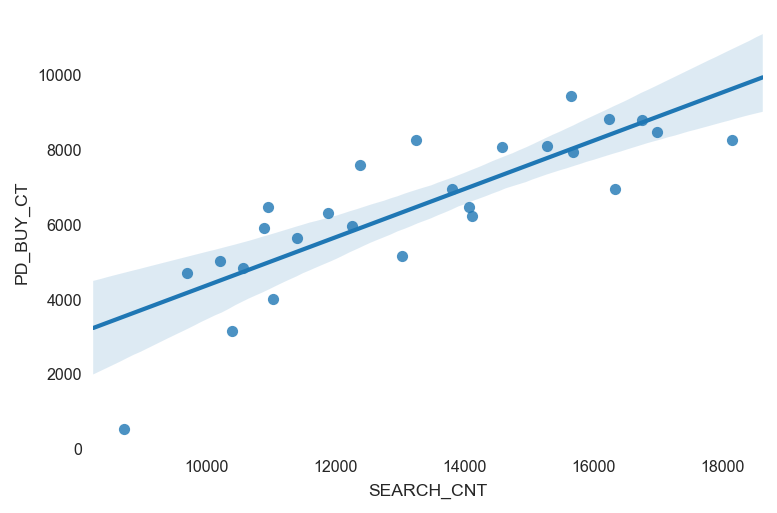

In [27]:
sns.regplot(data = groupday_df,x = 'SEARCH_CNT',y = 'PD_BUY_CT' )
sns.despine(left=True, bottom = True)

In [28]:
import statsmodels.api as sm

X = groupday_df.SEARCH_CNT
y =  groupday_df.PD_BUY_CT

X = sm.add_constant(X)
# Note the difference in argument order
model = sm.OLS(y, X).fit()
# predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

C:\anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PD_BUY_CT   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     52.40
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           1.77e-07
Time:                        20:16:46   Log-Likelihood:                -219.27
No. Observations:                  26   AIC:                             442.5
Df Residuals:                      24   BIC:                             445.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2094.1254   1204.627     -1.738      0.095   -4580.354     392.103
SEARCH_CNT     0.6464      0.089      7.239      0.000       0.462       0.831
==============================================================================
Omnibus:                        2.668   Durbin-Watson:                   0.631
Prob(Omnibus):                  0.263   Jarque-Bera (JB):                1.583
Skew:                          -0.594   Prob(JB):                        0.453
Kurtosis:                       3.223   Cond. No.                     7.15e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 워드클라우드

* 특정 상품군 대상 (여성의류) / 구매 데이터

1.빈도 워드클라우드
- 검색어
- 브랜드

2.트렌드 워드클라우드 주차별 비율 & 가중치
- 검색어
- 브랜드

In [9]:
pro = product[['CLNT_ID','SESS_ID','PD_C','PD_BRA_NM']]
sea = search1[['CLNT_ID','SESS_ID','KWD_NM']]
mas = master[['PD_C','CLAC1_NM']]
ses = session[['CLNT_ID','SESS_ID','SESS_DT']]

In [10]:
wordcloud_df = pd.merge(pro,mas, how = 'left')
wordcloud_df = pd.merge(wordcloud_df,sea, how = 'left', on = ['CLNT_ID','SESS_ID'])
wordcloud_df = pd.merge(wordcloud_df,ses, how = 'left', on = ['CLNT_ID','SESS_ID'])

In [11]:
def time_month(x):
    return int(str(x)[4:6])
    
def time_day(x):
    return int(str(x)[6:])

wordcloud_df['MONTH'] = wordcloud_df.SESS_DT.map(time_month)
wordcloud_df['DAY'] = wordcloud_df.SESS_DT.map(time_day)

In [12]:
wordcloud_df.head(3)

,CLNT_ID,SESS_ID,PD_C,PD_BRA_NM,CLAC1_NM,KWD_NM,SESS_DT,MONTH,DAY
0,4139680,7605037,642112,[바비브라운],화장품/뷰티케어,NaN,20180526,5,26
1,4140076,10189797,570603,데상트,스포츠패션,NaN,20180413,4,13
2,4142395,6158159,179538,[아베다],퍼스널케어,입생로랑,20180619,6,19


In [37]:
여성의류search_df = wordcloud_df[lambda x : x.CLAC1_NM == '여성의류']
여성의류search_df_month5 = 여성의류search_df[lambda x : x.MONTH == 5]

In [38]:
def word_prossessing(x):
    if len(x.split('[')) != 1:
        return (x.split('[')[1].split(']')[0])
    else: 
        return (x)
    
여성의류search_df_month5.PD_BRA_NM = 여성의류search_df_month5.PD_BRA_NM.map(word_prossessing)

C:\anaconda\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [84]:
여성의류search_dict_month5 = dict(여성의류search_df_month5.KWD_NM.value_counts())
여성의류brand_dict_month5 = dict(여성의류search_df_month5.PD_BRA_NM.value_counts())

In [40]:
from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter

- 1. 빈도워드클라우드

(-0.5, 492.5, 491.5, -0.5)

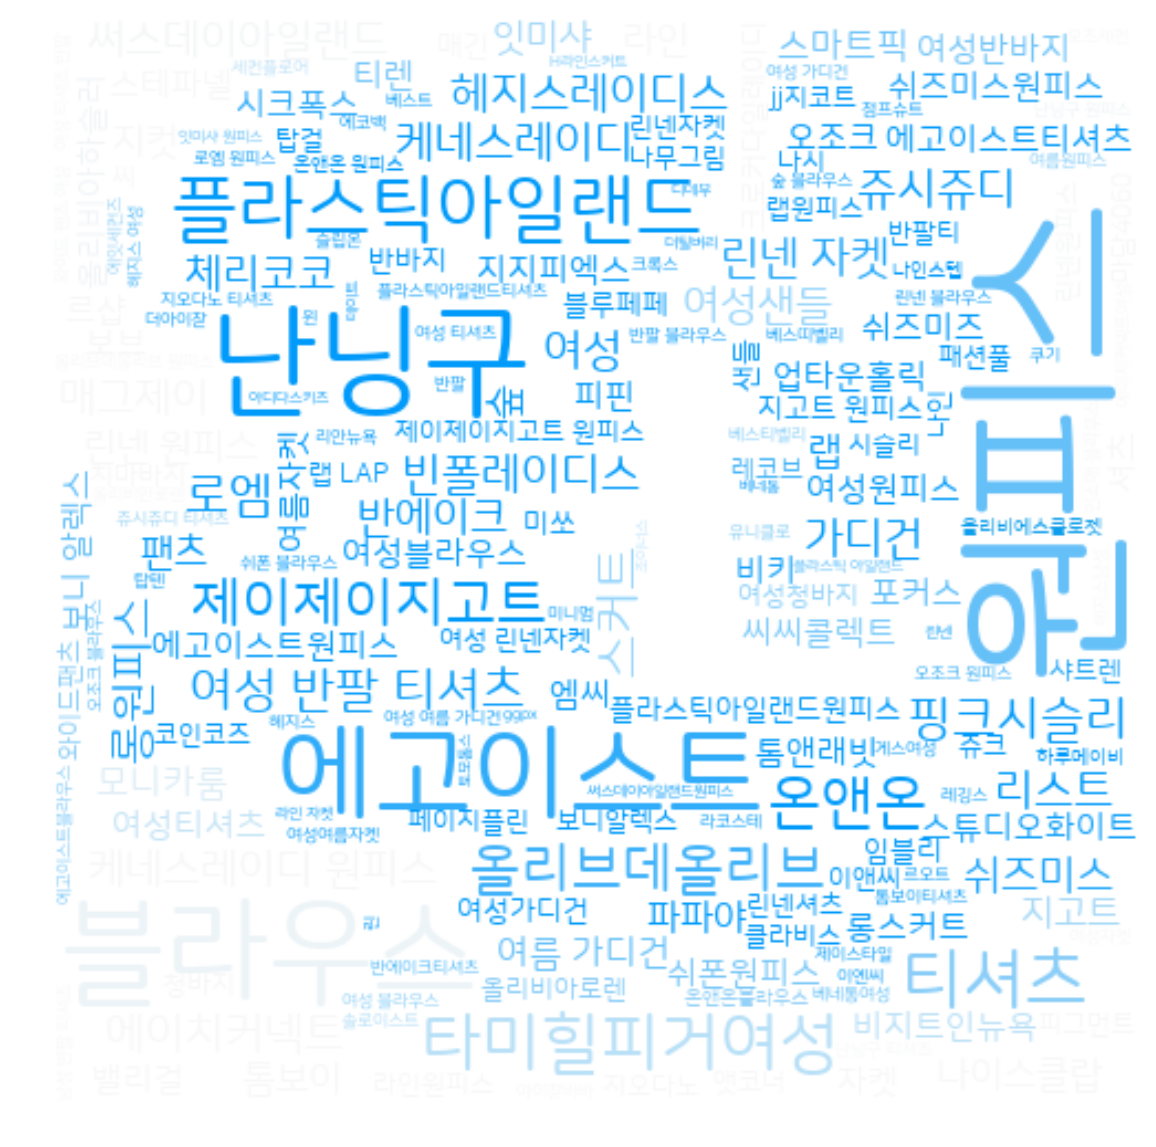

In [85]:
from wordcloud import ImageColorGenerator
lpoint = np.array(Image.open("lpoint.jpg"))
image_colors = ImageColorGenerator(lpoint)

wordcloud=WordCloud(font_path="c:/Windows/Fonts/NanumSquareRoundR.ttf",
                   background_color="white",
                    
                    mask=lpoint,
                    relative_scaling=1, # 빈도수 or 랭킹 을 고려할지!!
                    max_font_size=80
                   ).generate_from_frequencies(여성의류search_dict_month5) 

plt.figure(figsize=(10,10))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')

(-0.5, 492.5, 491.5, -0.5)

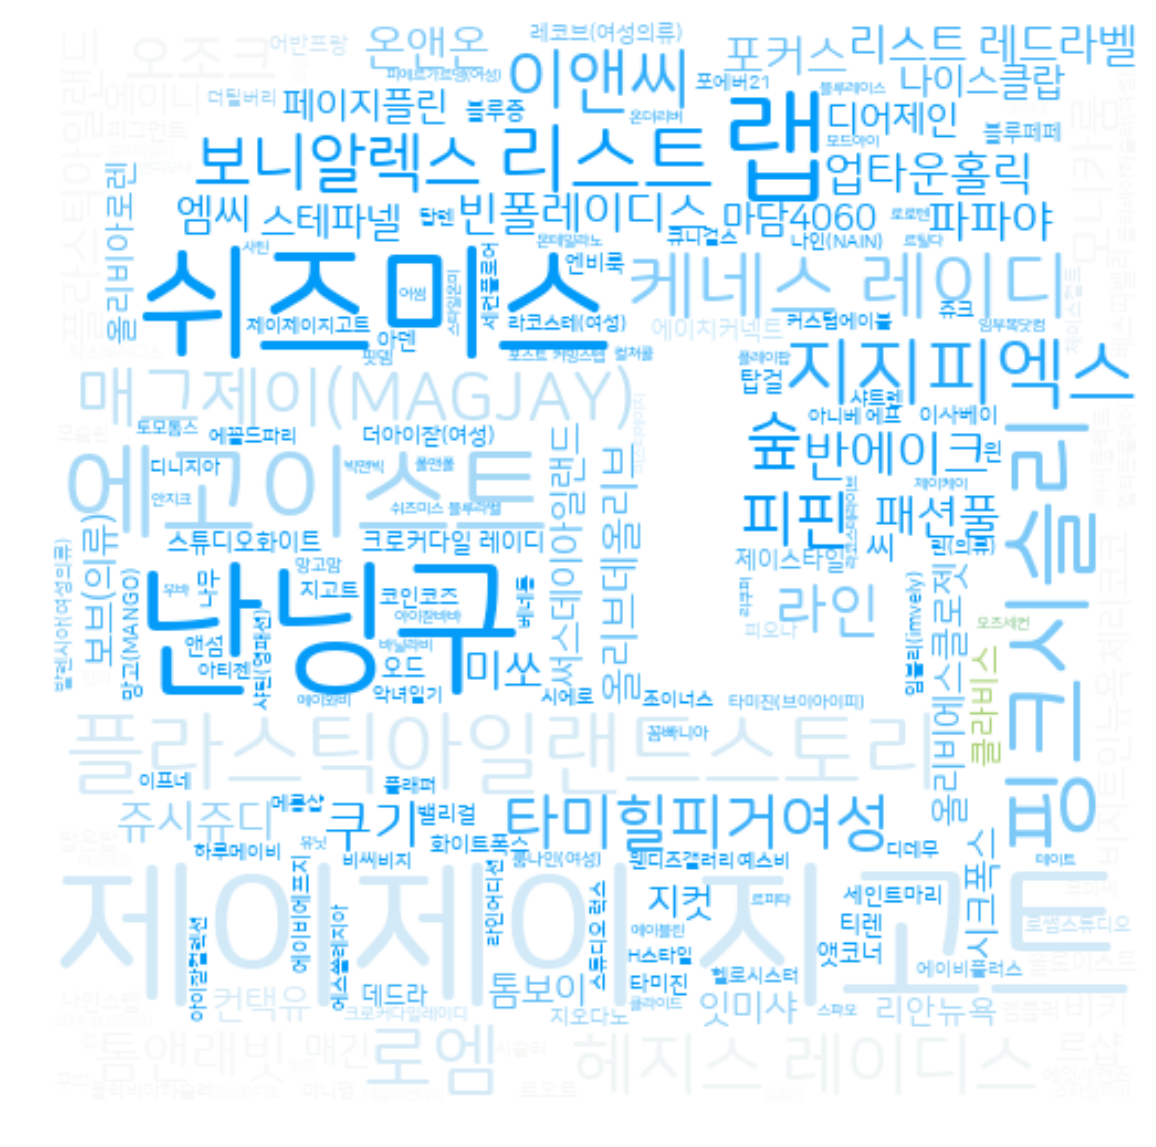

In [86]:
wordcloud=WordCloud(font_path="c:/Windows/Fonts/NanumSquareRoundR.ttf",
                   background_color="white",
                    mask=lpoint,
                    relative_scaling=1, # 빈도수 or 랭킹 을 고려할지!!
                    max_font_size=80
                   ).generate_from_frequencies(여성의류brand_dict_month5) 

plt.figure(figsize=(10,10))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')

- 2.트렌드워드클라우드
- 트렌드 수치 = (각 주차 빈도 / 전체 빈도) * (x 주 / 전체 주)
- 예시
트렌드 수치 = (1/10) * (1/4) + (3/10) * (2/4) + (4/10) * (3/4) + (3/10) * (4/4) = 0.775

In [43]:
여성의류search_df_month5.head()

,CLNT_ID,SESS_ID,PD_C,PD_BRA_NM,CLAC1_NM,KWD_NM,SESS_DT,MONTH,DAY
66,4205932,9135695,498175,매그제이(MAGJAY),여성의류,갤럭시s6 케이스,20180501,5,1
67,4205932,9135695,498175,매그제이(MAGJAY),여성의류,엘리자벳구두,20180501,5,1
68,4205932,9135695,498175,매그제이(MAGJAY),여성의류,하이웨스트,20180501,5,1
69,4205932,9135695,498175,매그제이(MAGJAY),여성의류,매그제이 바지,20180501,5,1
70,4205932,9135695,498175,매그제이(MAGJAY),여성의류,플라워스커트,20180501,5,1


In [44]:
여성의류search_df_month5['WEEK'] = 여성의류search_df_month5.DAY // 7

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [87]:
week1 = 여성의류search_df_month5[lambda x : x.WEEK == 0]
week2 = 여성의류search_df_month5[lambda x : x.WEEK == 1]
week3 = 여성의류search_df_month5[lambda x : x.WEEK == 2]
week4 = 여성의류search_df_month5[lambda x : x.WEEK.isin([3,4])]

In [102]:
# 검색어 트렌드 수치
week1_df = pd.DataFrame(week1.KWD_NM.value_counts())
week1_df.columns = ['week1']
week1_df.reset_index(inplace = True)
week2_df = pd.DataFrame(week2.KWD_NM.value_counts())
week2_df.columns = ['week2']
week2_df.reset_index(inplace = True)
week3_df = pd.DataFrame(week3.KWD_NM.value_counts())
week3_df.columns = ['week3']
week3_df.reset_index(inplace = True)
week4_df = pd.DataFrame(week4.KWD_NM.value_counts())
week4_df.columns = ['week4']
week4_df.reset_index(inplace = True)

week_df = pd.merge(week1_df,week2_df,how = 'outer')
week_df = pd.merge(week_df,week3_df,how = 'outer')
week_df = pd.merge(week_df,week4_df,how = 'outer')
week_df.fillna(0, inplace = True)

week_df['sum'] = week_df.week1 + week_df.week2 + week_df.week3 + week_df.week4
week_df['트렌드수치'] = ( week_df.week1*(1/4) + week_df.week2*(2/4) + week_df.week3*(3/4) + week_df.week4*(4/4) ) / week_df['sum']
week_df = week_df.set_index('index')
week_df = week_df[week_df['sum'] > week_df['sum'].mean()]

trend_KWD_NM_dict = week_df['트렌드수치'].to_dict()

(-0.5, 492.5, 491.5, -0.5)

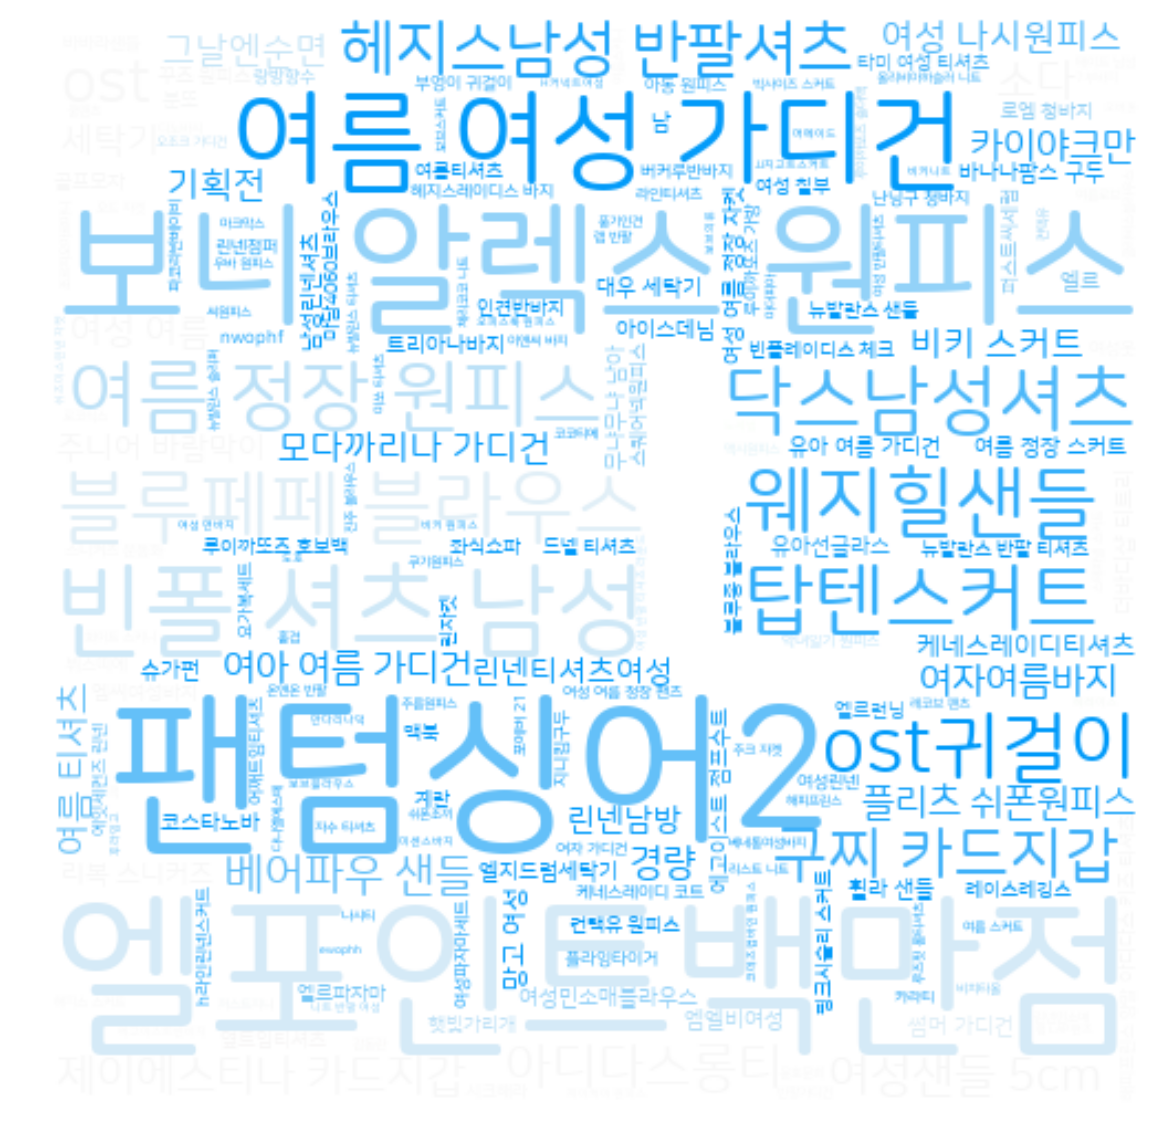

In [106]:
wordcloud=WordCloud(font_path="c:/Windows/Fonts/NanumSquareRoundR.ttf",
                   background_color="white",
                    mask=lpoint,
                    relative_scaling=1, # 빈도수 or 랭킹 을 고려할지!!
                    max_font_size=80
                   ).generate_from_frequencies(trend_KWD_NM_dict) 

plt.figure(figsize=(10,10))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')

In [100]:
# 브랜드 트렌드 수치
week1_df = pd.DataFrame(week1.PD_BRA_NM.value_counts())
week1_df.columns = ['week1']
week1_df.reset_index(inplace = True)
week2_df = pd.DataFrame(week2.PD_BRA_NM.value_counts())
week2_df.columns = ['week2']
week2_df.reset_index(inplace = True)
week3_df = pd.DataFrame(week3.PD_BRA_NM.value_counts())
week3_df.columns = ['week3']
week3_df.reset_index(inplace = True)
week4_df = pd.DataFrame(week4.PD_BRA_NM.value_counts())
week4_df.columns = ['week4']
week4_df.reset_index(inplace = True)

week_df = pd.merge(week1_df,week2_df,how = 'outer')
week_df = pd.merge(week_df,week3_df,how = 'outer')
week_df = pd.merge(week_df,week4_df,how = 'outer')
week_df.fillna(0, inplace = True)

week_df['sum'] = week_df.week1 + week_df.week2 + week_df.week3 + week_df.week4
week_df['트렌드수치'] = ( week_df.week1*(1/4) + week_df.week2*(2/4) + week_df.week3*(3/4) + week_df.week4*(4/4) ) / week_df['sum']
week_df = week_df.set_index('index')
week_df = week_df[week_df['sum'] > week_df['sum'].mean()]

trend_PD_BRA_NM_dict = week_df['트렌드수치'].to_dict()

(-0.5, 492.5, 491.5, -0.5)

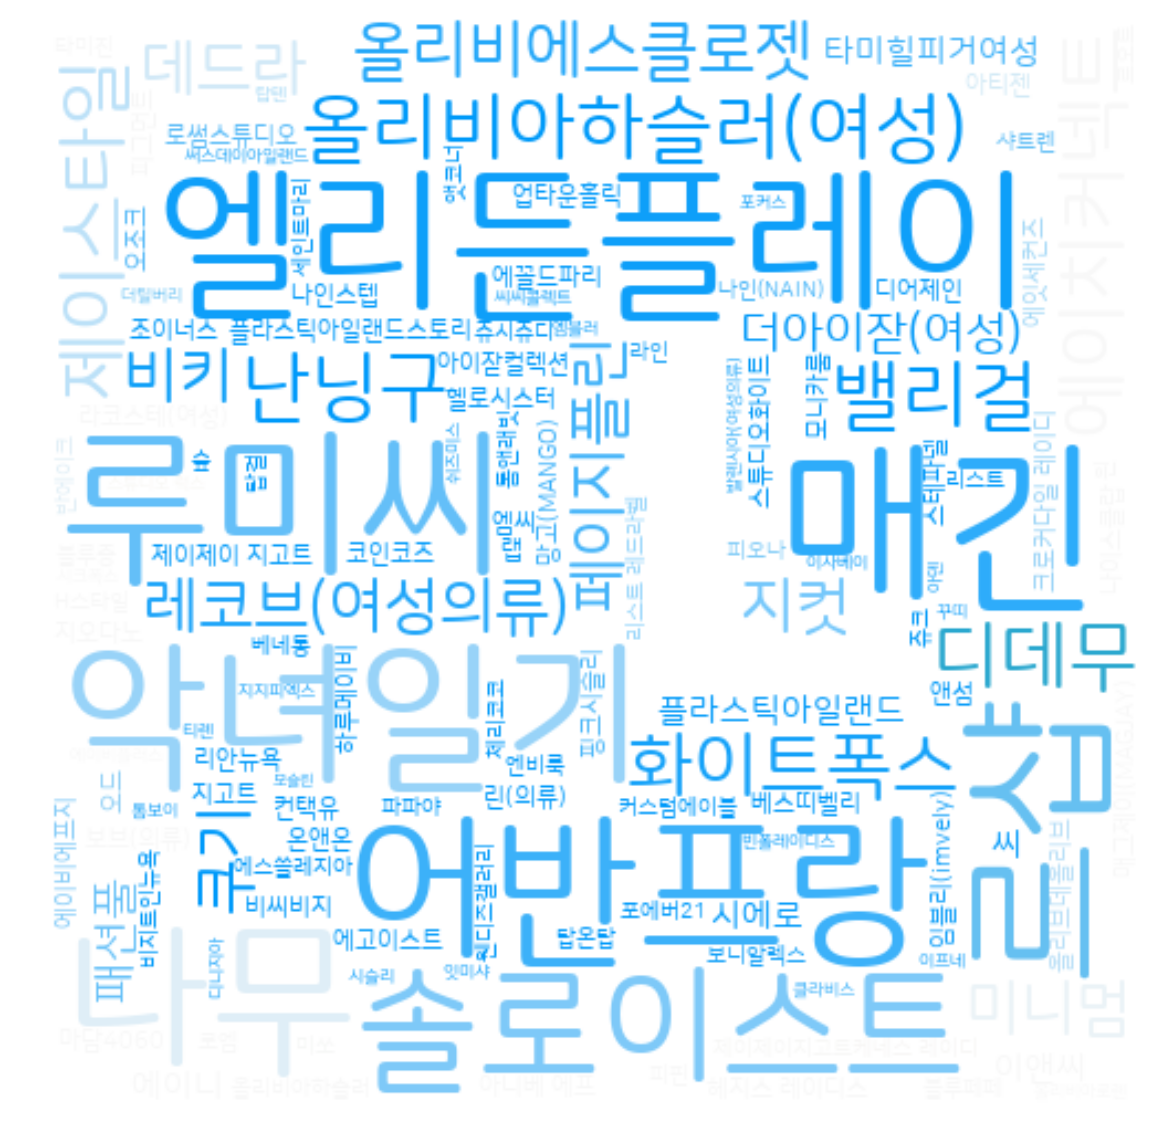

In [101]:
wordcloud=WordCloud(font_path="c:/Windows/Fonts/NanumSquareRoundR.ttf",
                   background_color="white",
                    mask=lpoint,
                    relative_scaling=1, # 빈도수 or 랭킹 을 고려할지!!
                    max_font_size=80
                   ).generate_from_frequencies(trend_PD_BRA_NM_dict) 

plt.figure(figsize=(10,10))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')